<a href="https://colab.research.google.com/github/oliverwsd/finance/blob/master/set4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
'''
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/data"

os.chdir(path)#将当前目录指定到了云盘data文件夹
#os.listdir(path)
pd.read_csv('monthly_factors.csv')
'''

'\nimport os\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\npath = "/content/drive/My Drive/data"\n\nos.chdir(path)#将当前目录指定到了云盘data文件夹\n#os.listdir(path)\npd.read_csv(\'monthly_factors.csv\')\n'

In [3]:
from io import StringIO
import csv


url = 'https://raw.githubusercontent.com/oliverwsd/finance/master/monthly_factors.csv'
factors = pd.read_csv(url)
factors.head()

,date,rm,rf,SMB,HML,WML
0,196207,-5.53,0.25,-0.29,-1.05,2.38
1,196208,6.11,0.25,-5.50,-1.63,0.80
2,196209,-6.32,0.26,2.26,0.14,1.94
3,196210,-2.03,0.24,-3.12,1.13,1.14
4,196211,19.29,0.24,-0.87,-9.73,-10.36


In [4]:
# Read-in the factors for German market from the provided file 'monthly_factors.csv' (rf is risk free rate):
#   1. rm (Market factor)
#   2. SMB (Fama-French size factor)
#   3. HML (Fama-French value factor)
#   4. WML (Carhart momentum factor)
# Like above, convert the 'date' column to the datetime data type.
#
#factors         = pd.read_csv('monthly_factors.csv')
factors['date'] = pd.to_datetime(factors['date'], format ='%Y%m')
factors['rm_excess'] = factors['rm'] - factors['rf']
factors = factors[['date', 'rm_excess', 'rf']]  # We'll only use market excess returns and riskfree rate here
factors[['rm_excess', 'rf']] /= 100  # Bring numbers to actual values
factors.head()

,date,rm_excess,rf
0,1962-07-01,-0.0578,0.0025
1,1962-08-01,0.0586,0.0025
2,1962-09-01,-0.0658,0.0026
3,1962-10-01,-0.0227,0.0024
4,1962-11-01,0.1905,0.0024


In [10]:
# We will estimate an ARMA(1, 1) model on market excess returns and the riskfree rate:
#
#    r_t = \alpha + \beta * r_{t-1} + \epsilon_t + \theta * \epsilon_{t-1}   (1)
#
# This means: We need to come up with estimates for the parameters \alpha, \beta and \theta
#
# The problem is: \epsilon_{t-1} is not observed, we only have observations for r_t, r_{t-1}.
# We will follow a two-pass estimation to circumvent this problem. We first estimate the
# AR part of that model via OLS:
#
#    r_t = \alpha + \beta * r_{t-1} + \tilde{\epsilon}_t                      (2)
#
# Given this model, we can get a time series of \tilde{\epsilon}_t. With that, we can now
# estimate (1) via OLS, by just setting \epsilon_{t-1} = \tilde{\epsilon}_{t-1}.


# Task 1: Estimate AR model part (Step 1)
# ---------------------------------------

# Estimate the model (2) for market excess returns via OLS using the statsmodels package.
#
# Hint: If you are insecure what to do, write down the regression formulas for the factor
#       models of the last problem set and compare.
# Note: 'ar_model_rm_excess' should contain the OLS regression result object (after fitting)
#
# IMPORTANT: Use the constant as first variable in the regression. This also applied to the
#            next regression!
X = pd.DataFrame()
rm_excess_x = list(factors['rm_excess'])
rm_excess_y = list(factors['rm_excess'])
X['alpha'] = np.ones(len(factors['rm_excess'])-1)
X['rm_excess'] = rm_excess_x[:-1]
Y = rm_excess_y[1:]
ar_model_rm_excess = sm.OLS(Y,X).fit()
print(ar_model_rm_excess.summary())

# Repeat the analysis above for the riskfree rate.
#
# Note: 'ar_model_rf' should contain the OLS regression result object
X = pd.DataFrame()
rf_x = list(factors['rf'])
rf_y = list(factors['rf'])
X['alpha'] = np.ones(len(factors['rf'])-1)
X['rf'] = rf_x[:-1]
Y = rf_y[1:]
ar_model_rf = sm.OLS(Y,X).fit()
print(ar_model_rf.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.605
Date:                Fri, 06 Dec 2019   Prob (F-statistic):             0.0104
Time:                        08:08:45   Log-Likelihood:                 964.88
No. Observations:                 617   AIC:                            -1926.
Df Residuals:                     615   BIC:                            -1917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0038      0.002      1.833      0.0

In [20]:
# Task 2: Estimate full ARMA model (Step 2)
# -----------------------------------------
tilde = list(rm_excess_y[1:]- (ar_model_rm_excess.params[0]+factors['rm_excess'][0:-1]*ar_model_rm_excess.params[1]))
X = pd.DataFrame()
X['constant'] = np.ones(len(factors['rm_excess'])-2)   
X['rm_excess'] = rm_excess_x[1:-1]  
X['epsilon'] = tilde[:-1]   
Y = rm_excess_y[2:]                                                             
arma_model_rm_excess = sm.OLS(Y,X).fit()
print(arma_model_rm_excess.summary())

#长度对的， 取值不对，范围需要修改

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.550
Date:                Fri, 06 Dec 2019   Prob (F-statistic):             0.0293
Time:                        08:19:57   Log-Likelihood:                 963.64
No. Observations:                 616   AIC:                            -1921.
Df Residuals:                     613   BIC:                            -1908.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0044      0.003      1.680      0.0

In [57]:
# Repeat the ARMA model estimation for the riskfree rate.
#
# Note: 'arma_model_rf' should contain the OLS regression result object (after fitting)
tilde = rf_y[1:] - (ar_model_rf.params[0]+factors['rf'][0:-1]*ar_model_rf.params[1])
X = pd.DataFrame()
X['constant'] = np.ones(len(factors['rf'])-2)   
X['rf'] = rf_x[1:-1]  
X['epsilon'] = tilde[:-1]    
Y = rf_y[2:]                                                             
arma_model_rf = sm.OLS(Y,X).fit()
print(arma_model_rf.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     7602.
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:30:38   Log-Likelihood:                 3854.8
No. Observations:                 616   AIC:                            -7704.
Df Residuals:                     613   BIC:                            -7690.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    4.459e-05   3.81e-05      1.169      0.2

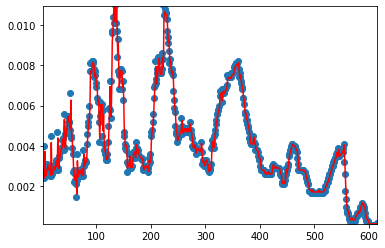

In [56]:
y_hat_rf = arma_model_rf.predict(X) #ols预测值
list0 = np.array(range(1,617))    
plt.axis([min(list0),max(list0),min(y_hat_rf),max(y_hat_rf)])
#plt.ylim(y_min, y_max)
plt.scatter(list0,rf_y[2:])
plt.plot(list0,y_hat_rf,'r')

In [0]:
#残差正态分布
residual = arma_model_rm_excess.resid
result = arma_model_rm_excess
pq = sm.ProbPlot(arma_model_rm_excess.resid)
pq.qqplot(line='q')
pq.ppplot(line='45')
#pp图和qq图判断标准是：如果观察点都比较均匀的分布在直线附近，就可以说明变量近似的服从正态分布，否则不服从正态分布。

import scipy.stats as stats
stats.shapiro(arma_model_rm_excess.resid)
#上面结果两个参数：第一个是Shaprio检验统计量值，第二个是相对应的p值。可以看到，p值非常小，远远小于0.05，因此拒绝原假设，说明残差不服从正态分布。

#残差的独立性
# DW = 2, 扰动项无相关性
# DW = 0, 扰动项完全正相关
# DW = 4，扰动项完全负相关
#Durbin-Watson: 1.989 -> 无关，满足独立性假设

#方差齐性检验（无明显自相关）
sm.stats.diagnostic.het_breuschpagan(residual,result.model.exog)
#9.516504691510487         LM统计量值
#0.008580592209694694      响应的p值，0.008远小于显著性水平0.05，因此拒绝原假设，即残差方差不是一个常数
#4.809378508254906         F统计量值，用来检验残差平方项与自变量之间是否独立，如果独立则表明残差方差齐性
#0.008463131883886393      F统计量对应的p值，也是远小于0.05的，进一步验证了残差方差的非齐性，存在自相关

In [0]:
# Is the parameter for the AR part, beta, significant to the 5% confidence level in the ARMA model for
# market excess returns?
#
# If so, set ar_significant_rm_excess = 'yes'. Otherwise, set ar_significant_rm_excess = 'no'.
ar_significant_rm_excess = 'no'

# Repeat the ARMA model estimation for the riskfree rate.
#
# Note: 'arma_model_rf' should contain the OLS regression result object (after fitting)

 
# Is the parameter for the AR part, beta, significant to the 5% confidence level in the ARMA model for
# the riskfree rate?
#
# If so, set ar_significant_rf = 'yes'. Otherwise, set ar_significant_rf = 'no'.
ar_significant_rf = 'yes'



In [0]:
# Task 3: Predict returns
# -----------------------

# Predict market excess returns based on the ARMA model. That means, given information
# in t, predict the value of the market excess return in t+1. Use the epsilon estimates
# that you also used in the parameter estimation above. Do only predict those returns
# for which we have observations (i.e. do not make the prediction at the last point of
# the time series, as we do not have an observation after that).

E_rm_excess =
# Hint: E_rm_excess.shape should be (616,)


# Repeat the same for the riskfree rate and predict it using its ARMA model parameters.
# Again, do not make a prediction for the last point of the time series and use the
# epsilon estimates that you used in the estimation above.

E_rf =
# Hint: E_rf.shape should be (616,)


# Plot expectations and realization
fig, ax = plt.subplots(2, 1)
ax[0].plot(factors['date'].iloc[2:].values, factors['rm_excess'].iloc[2:].values, label = 'Realizations')
ax[0].plot(factors['date'].iloc[2:].values, E_rm_excess, label = ['Expectations'])
ax[0].set_title("Market excess return")
ax[0].legend()
ax[1].plot(factors['date'].iloc[2:].values, factors['rf'].iloc[2:].values, label = 'Realizations')
ax[1].plot(factors['date'].iloc[2:].values, E_rf, label = ['Expectations'])
ax[1].set_title("Riskfree rate")
ax[1].legend()
plt.show()


# What is the unconditional expectation of the riskfree rate, that is implied
# by the ARMA model?
#
# Hint: Derive the formula for the unconditional expectation at first.
unconditional_E_rf =


# Check of intermediate result (3):
#
# HINT: Check for yourself: E_rm_excess[23] should be 0.0071  (rounded to 4 digits)
#       Check for yourself: E_rf[23] should be 0.0028  (rounded to 4 digits)